# Recomendação via Fatorização de matrizes (Matrix factorization)

Num projeto anterior, fizemos o completamento de matrizes (por exemplo para sistemas de recomendação como o Netflix) usando uma abordagem *convexa*: algoritmos de otimização de um problema com regularização convexa (norma nuclear). 

Uma segunda abordagem bem sucedida é estimar a matriz não observada $X^*$ resolvendo o problema:

$$\min_X f(X)=f(U,V):=\frac 1 2 \|U V^\top - Y\|^2_F,$$

onde $Y\in {\mathbb R}^{m\times n}$ é a matriz observada, $U\in {\mathbb R}^{m\times r}$, $V\in {\mathbb R}^{n\times r}$ and $r<\min\{m,n\}$. O gradiente é dado por 

$$
\nabla f(X) = [(UV^\top -Y) V, (UV^\top-Y)^\top U].
$$

Note que diferentemente do caso convexo (onde tínhamos a penalização $\lambda>0$ da norma nuclear como hyper-parâmetro), nesta abordagem temos uma estimativa do posto $r$ como hyper-parâmetro. A idéia aqui é "regularizar" a solução com posto $r$ impondo a fatorização $U V^\top$. Do ponto de vista computacional, a diferença é que o problema é não convexo. Entretanto, algoritmos de otimização iterativos funcionam bem na prática. 

Iremos utilizar os dados [Movielens 100K dataset](https://grouplens.org/datasets/movielens/100k/). Em particular usamos o arquivo `u.data` desta pasta, gravado em `~/datasets`. Este arquivo tem avaliações de filmes de 943 usuários e 1682 filmes. Começamos carregando alguns módulos necessários:

In [2]:
#Chamando módulos necessários:
import cupy as np
import scipy.linalg as LA
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import scipy.sparse as spr
import scipy.sparse.linalg as spr_LA

À seguir iremos carregar os dados e escrevê-los numa matriz esparsa $Y$.

In [3]:
#Carregando dados:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('datasets/u.data', sep='\t', names=names)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]

#Criando a matriz Y de avaliações:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

Y = ratings
m, n = Y.shape
print("As dimensões de Y são:", m, n)

As dimensões de Y são: 943 1682


# Exercício 1: Funções auxiliares

1. Construa uma função `f()` que toma $X=(U,V)$ e retorna o valor funcional $f(X)=\frac 1 2 \|U V^\top - Y\|^2_F$.
2. Construa uma função `df()` que toma $X=(U,V)$ e retorna o gradiente $\nabla f(X) = [(UV^\top -Y) V, (UV^\top-Y)^\top U]$.
3. Construa uma função `J()` que dada matriz $D$ retorna a norma de Frobenius $\Vert D\Vert_F$.

In [4]:
#Escreva código aqui
def J(D:np.ndarray) -> float:
    return np.linalg.norm(D, 'fro')

def f(X:tuple[np.ndarray, np.ndarray], Y:np.ndarray) -> float:
    U, V = X
    diff = U @ V.T - Y
    return (J(diff)**2) / 2

def df(X:tuple[np.ndarray, np.ndarray], Y:np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    U, V = X
    diff = U @ V.T - Y
    dU = diff @ V
    dV = diff.T @ U
    return dU, dV

# Inicialização

À seguir ponha `r=20` e inicialize $X_0=(U_0,V_0)$ aleatoriamente de uma normal multivariada. Para tanto use
`np.random.randn()`. Ponha `N=30000` para o número de iterações. 

In [5]:
r = 20

# the starting point 
np.random.seed(0)
X0 = (np.random.randn(m, r), np.random.randn(n, r))

# number of iterations
N = 30000

# Exercício 2: Método do gradiente

Construa uma função `gd(J, df, x0, la=1, numb_iter=100)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente iniciando de `x0`. Esta função deve retornar a sequência de valores da função `J(df(x))` em cada um dos iterados `x`, isto é, a sequência das normas dos gradientes ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com passo `la=1./L` com `L=1000`.

In [6]:
#Escreva código aqui
def gd(J, df, X0, la=1, numb_iter=100):
    U, V = X0[0].copy(), X0[1].copy()
    grad_norms = list()

    for i in range(numb_iter):
        dU, dV = df((U, V), Y)
        
        grad_norm = J(dU) + J(dV)
        grad_norms.append(float(grad_norm))
        
        U -= la * dU
        V -= la * dV

    return grad_norms, (U, V)

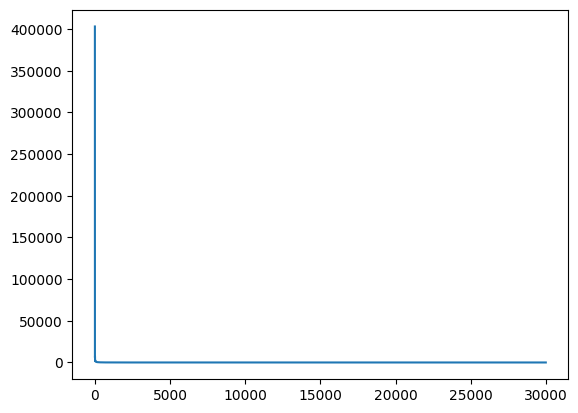

In [6]:
# gradient descent
L = 1000
f1 = gd(J, df, X0, 1./L, numb_iter=N)
plt.plot(f1[0])

# Exercício 3: Método do gradiente acelerado

Construa uma função `accel_gd(J, df, x0, la=1, numb_iter=100)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente com aceleração de Nesterov iniciando de `y_0=x0` e $t_0=1$:
\begin{align*}
X_{k+1}&:= Y_k - la\nabla f(Y_k),\\
t_{k+1} &:= \frac{1+\sqrt{1+4t_k^2}}{2},\\
Y_{k+1} &:= X_{k+1} + \frac{t_{k}-1}{t_{k+1}}(X_{k+1}-X_{k}).
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(y))` em cada um dos iterados `y`, isto é, a sequência das normas dos gradientes de $Y_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com passo `la=1./L` com `L=30000`.

In [7]:
#Escreva código aqui
def accel_gd(J, df, x0, la=1, numb_iter=100):
    U, V = X0[0].copy(), X0[1].copy()
    Y_U, Y_V = U.copy(), V.copy()
    t = 1
    grad_norms = list()

    for i in range(numb_iter):
        dU, dV = df((Y_U, Y_V), Y)
        
        grad_norm = J(dU) + J(dV)
        grad_norms.append(float(grad_norm))
        
        X_U = Y_U - la * dU
        X_V = Y_V - la * dV
        
        t_next = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        
        Y_U = X_U + ((t - 1) / t_next) * (X_U - U)
        Y_V = X_V + ((t - 1) / t_next) * (X_V - V)
        
        U, V = X_U, X_V
        t = t_next

    return grad_norms, (U, V)

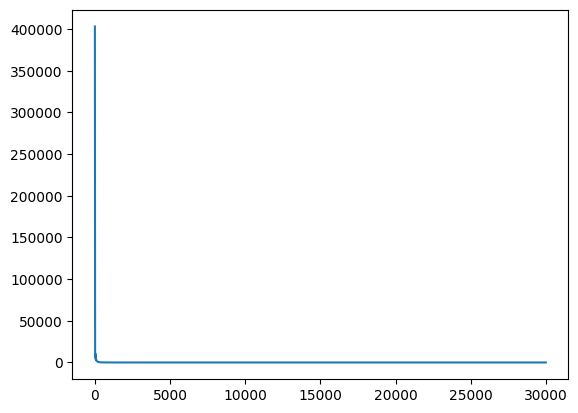

In [8]:
# Nesterov accelerated gradient descent
L = 30000
f2 = accel_gd(J, df, X0, 1./L, numb_iter=N)
plt.plot(f2[0])

# Exercício 4: Adagrad-Norm

Construa uma função `ad_grad_norm(J, df, x0, b0=0.5, eta=1, numb_iter=100)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, parametros positivos `b0` e `eta` e o número de iterações `numb_iter` e implementa o método Adagrad-Norm iniciando de `x0`:
\begin{align*}
X_{k+1}&:= X_k - \frac{\eta}{\sqrt{b_0^2 + \sum_{j=1}^k\Vert\nabla f(X_j)\Vert_2^2}} \nabla f(X_k).
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(x))` em cada um dos iterados `x`, isto é, a sequência das normas dos gradientes de $X_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com `b0=0.5` e `eta=1`.

In [8]:
#Escreva código aqui
def ad_grad_norm(J, df, X0, b0=0.5, eta=1.0, numb_iter=100):
    U, V = X0[0].copy(), X0[1].copy()
    grad_norms = list()
    grad_norm_sum = 0

    for i in range(numb_iter):
        dU, dV = df((U, V), Y)
        
        grad_norm = J(dU) + J(dV)
        grad_norms.append(float(grad_norm))
        
        grad_norm_sum += grad_norm ** 2
        
        step_size = eta / np.sqrt(b0 ** 2 + grad_norm_sum)
        
        U -= step_size * dU
        V -= step_size * dV

    return grad_norms, (U, V)

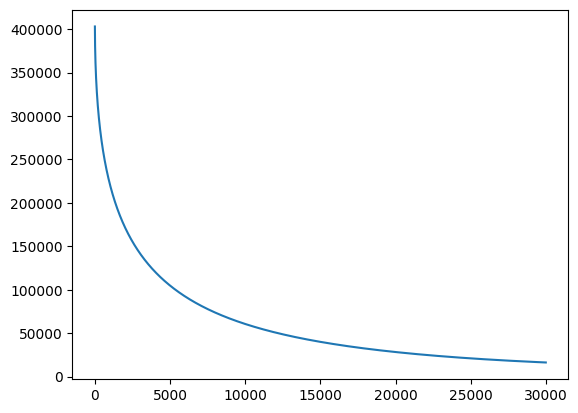

In [10]:
# Adagrad-Norm
f3 = ad_grad_norm(J, df, X0, b0=0.5, eta=1, numb_iter=N)
plt.plot(f3[0])

# Exercício 5: Adam

Construa uma função `adam(J, df, x0, alpha, beta1, beta2, epsilon, numb_iter)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, parametros positivos `alpha`, `beta1`, `beta2`, `epsilon` e o número de iterações `numb_iter` e implementa o método Adam iniciando de `x0`, $m_0=0$, $v_0=0$ e $k=0$: para cada $j$ézima coordenada:
\begin{align*}
m_{k+1}[j] &:= \beta_1\cdot m_{k}[j] + (1-\beta_1)\cdot\nabla f(X_k)[j],\\
v_{k+1}[j] &:= \beta_2\cdot v_{k}[j] + (1-\beta_2)\cdot(\nabla f(X_k)[j])^2,\\
\hat m_{k+1}[j] &:= \frac{1}{1-\beta_1^{k+1}}m_{k+1}[j],\\
\hat v_{k+1}[j] &:= \frac{1}{1-\beta_2^{k+1}}v_{k+1}[j],\\
X_{k+1}[j] &:= X_{k}[j] - \frac{\alpha}{\sqrt{\hat v_{k+1}[j]} + \epsilon}\hat m_{k+1}[j].
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(x))` em cada um dos iterados `x`, isto é, a sequência das normas dos gradientes de $X_k$ ao longo da trajetória do método. A função também deve retornar o último iterado. 

Implemente a função com `alpha=0.001`, `beta1=0.9`, `beta2=0.999`, `epsilon=10**(-8)`. 

In [9]:
#Escreva código aqui
def adam(J, df, X0, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, numb_iter=100):
    U, V = X0[0].copy(), X0[1].copy()
    m_U, m_V = np.zeros_like(U), np.zeros_like(V)
    v_U, v_V = np.zeros_like(U), np.zeros_like(V)
    grad_norms = list()

    for k in range(1, numb_iter + 1):
        dU, dV = df((U, V), Y)

        m_U = beta1 * m_U + (1 - beta1) * dU
        m_V = beta1 * m_V + (1 - beta1) * dV

        v_U = beta2 * v_U + (1 - beta2) * dU ** 2
        v_V = beta2 * v_V + (1 - beta2) * dV ** 2
        
        m_U_chapeu = m_U / (1 - beta1 ** k)
        m_V_chapeu = m_V / (1 - beta1 ** k)

        v_U_chapeu = v_U / (1 - beta2 ** k)
        v_V_chapeu = v_V / (1 - beta2 ** k)
        
        U -= alpha * m_U_chapeu / (np.sqrt(v_U_chapeu) + epsilon)
        V -= alpha * m_V_chapeu / (np.sqrt(v_V_chapeu) + epsilon)
        
        grad_norm = J(dU) + J(dV)
        grad_norms.append(float(grad_norm))
    
    return grad_norms, (U, V)

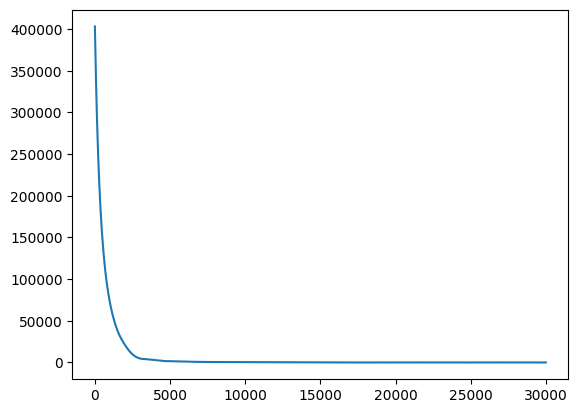

In [12]:
# Adam
f4 = adam(J, df, X0, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10**(-8), numb_iter=N)
plt.plot(f4[0])

# Exercício 6: 

Implemente num mesmo gráfico os erros $\Vert\nabla f(X_k)\Vert$ de cada método em função no número de iterações.

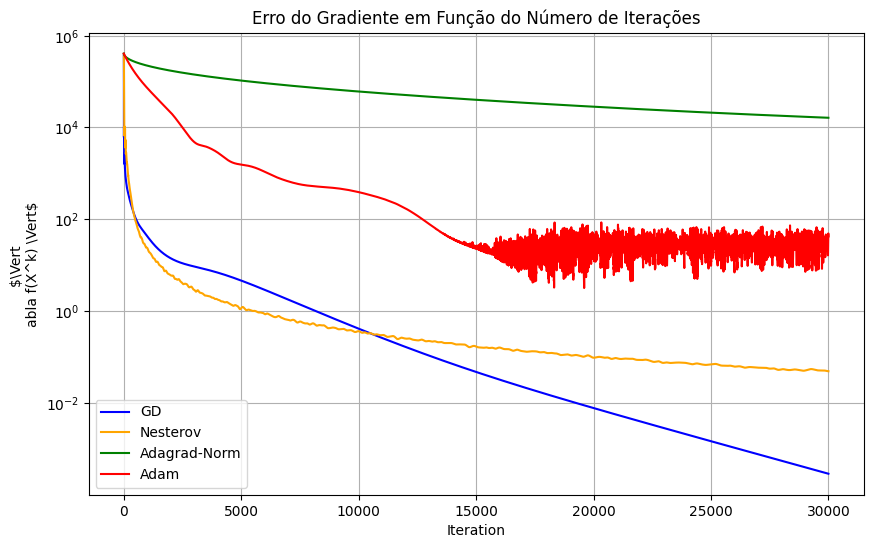

In [ ]:
#Escreva código aqui
plt.figure(figsize=(10, 6))
plt.plot(f1[0], label='GD', color='blue')
plt.plot(f2[0], label='Nesterov', color='orange')
plt.plot(f3[0], label='Adagrad-Norm', color='green')
plt.plot(f4[0], label='Adam', color='red')

plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel("$\Vert \nabla f(X^k) \Vert$")
plt.legend()
plt.grid(True)
plt.show()

# Exercício 7:

Experimente com os hyper-parâmetros de Adagrad-Norm e Adam para ver se eles podem chegar perto ou superar a performance de GD e Nesterov. Plote o gráfico como no Exercício 6. 

In [ ]:
# Adam
import optuna
import cupy as np

# Função exemplo de perda (norma do gradiente)
def J(gradient):
    return np.linalg.norm(gradient)

# Função objetivo para Adagrad-Norm
def objective_adagrad(trial):
    # Hiperparâmetros a serem otimizados
    b0 = trial.suggest_float("b0", 0.1, 1.0, log=True)
    eta = trial.suggest_float("eta", 0.01, 1.0, log=True)
    numb_iter = 2000

    # Defina df (gradiente) e ponto inicial X0
    df = lambda X, Y: (2 * X[0], 2 * X[1])  # Exemplo de função de gradiente
    X0 = (np.array([5.0, 5.0]), np.array([5.0, 5.0]))
    Y = None  # Parâmetro adicional, se necessário

    # Execute Adagrad-Norm com os parâmetros testados
    grad_norms, final_X = ad_grad_norm(J, df, X0, b0=b0, eta=eta, numb_iter=numb_iter)

    # Retorne o valor final da norma do gradiente para o Optuna
    return grad_norms[-1]

# Função objetivo para Adam
def objective_adam(trial):
    # Hiperparâmetros a serem otimizados
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    beta1 = trial.suggest_float("beta1", 0.8, 0.99)
    beta2 = trial.suggest_float("beta2", 0.9, 0.9999)
    epsilon = trial.suggest_float("epsilon", 1e-8, 1e-6, log=True)
    numb_iter = 2000

    # Defina df (gradiente) e ponto inicial X0
    df = lambda X, Y: (2 * X[0], 2 * X[1])  # Exemplo de função de gradiente
    X0 = (np.array([5.0, 5.0]), np.array([5.0, 5.0]))
    Y = None  # Parâmetro adicional, se necessário

    # Execute Adam com os parâmetros testados
    grad_norms, final_X = adam(J, df, X0, alpha=alpha, beta1=beta1, beta2=beta2, epsilon=epsilon, numb_iter=numb_iter)

    # Retorne o valor final da norma do gradiente para o Optuna
    return grad_norms[-1]

# Executar a otimização para Adagrad-Norm
study_adagrad = optuna.create_study(direction="minimize")
study_adagrad.optimize(objective_adagrad, n_trials=30)
print("Melhores hiperparâmetros para Adagrad-Norm:", study_adagrad.best_params)

# Executar a otimização para Adam
study_adam = optuna.create_study(direction="minimize")
study_adam.optimize(objective_adam, n_trials=30)
print("Melhores hiperparâmetros para Adam:", study_adam.best_params)

[I 2024-11-11 17:49:49,057] A new study created in memory with name: no-name-dc568943-9494-4100-9400-c59848243869
[I 2024-11-11 17:49:49,495] Trial 0 finished with value: 14.212964408370098 and parameters: {'b0': 0.2792281663210602, 'eta': 0.09044585060401429}. Best is trial 0 with value: 14.212964408370098.
[I 2024-11-11 17:49:49,840] Trial 1 finished with value: 21.348879730518213 and parameters: {'b0': 0.3081743783532652, 'eta': 0.041409125668611574}. Best is trial 0 with value: 14.212964408370098.
[I 2024-11-11 17:49:50,169] Trial 2 finished with value: 0.0008158923583634869 and parameters: {'b0': 0.20395391867823057, 'eta': 0.524536845679272}. Best is trial 2 with value: 0.0008158923583634869.
[I 2024-11-11 17:49:50,498] Trial 3 finished with value: 10.27771597696382 and parameters: {'b0': 0.8471381165903545, 'eta': 0.12286139653793242}. Best is trial 2 with value: 0.0008158923583634869.
[I 2024-11-11 17:49:50,829] Trial 4 finished with value: 23.36992001761954 and parameters: {'b

Melhores hiperparâmetros para Adagrad-Norm: {'b0': 0.10061725732600074, 'eta': 0.9978693661290544}


[I 2024-11-11 17:50:05,063] Trial 0 finished with value: 0.1182609633547745 and parameters: {'alpha': 0.0024436139589738975, 'beta1': 0.9528043431782494, 'beta2': 0.9146390039021253, 'epsilon': 8.755817856970313e-08}. Best is trial 0 with value: 0.1182609633547745.
[I 2024-11-11 17:50:05,673] Trial 1 finished with value: 23.420041774886247 and parameters: {'alpha': 0.00042845299199606386, 'beta1': 0.9866252334309277, 'beta2': 0.9654609204081487, 'epsilon': 1.0987287570686697e-07}. Best is trial 0 with value: 0.1182609633547745.
[I 2024-11-11 17:50:06,280] Trial 2 finished with value: 25.736543997730593 and parameters: {'alpha': 0.0002260403271811704, 'beta1': 0.9109896795613356, 'beta2': 0.9884019219753117, 'epsilon': 9.914631815342805e-07}. Best is trial 0 with value: 0.1182609633547745.
[I 2024-11-11 17:50:06,895] Trial 3 finished with value: 27.508636753890016 and parameters: {'alpha': 6.85983159661395e-05, 'beta1': 0.8642779609311291, 'beta2': 0.9324113273909089, 'epsilon': 2.78806

KeyboardInterrupt: 

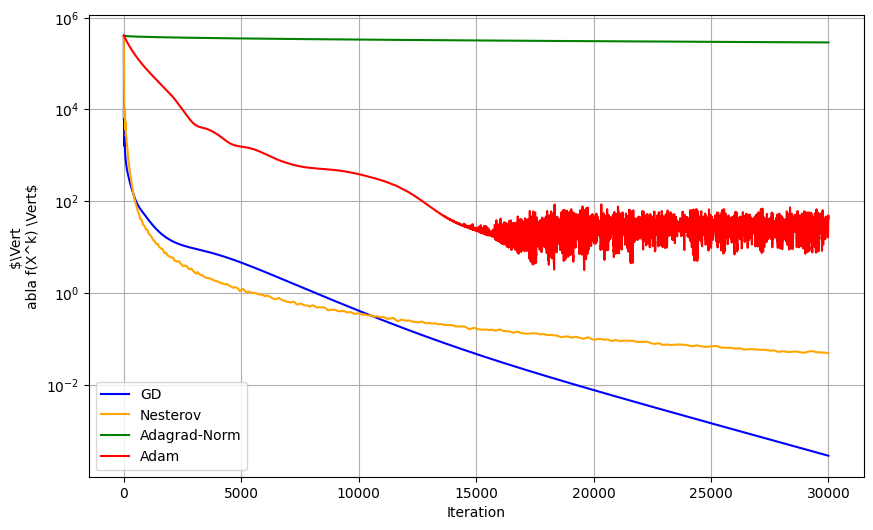

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(f1[0], label='GD', color='blue')
plt.plot(f2[0], label='Nesterov', color='orange')
plt.plot(f3[0], label='Adagrad-Norm', color='green')
plt.plot(f4[0], label='Adam', color='red')

plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel("$\Vert \nabla f(X^k) \Vert$")
plt.legend()
plt.grid(True)
plt.show()